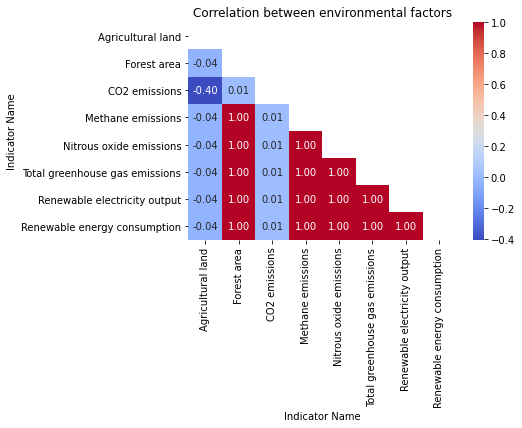

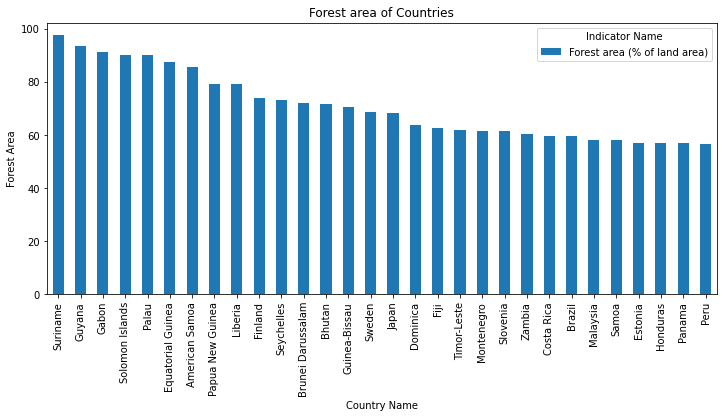

AttributeError: module 'cluster_tools' has no attribute 'scaler'

In [2]:
import pycountry
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from err_ranges import err_ranges
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
import cluster_tools as cl_tool

# Function to read World Bank data from a CSV file and return two dataframes
def load_worldbank_data(file):
    """
    This function loads the data and converts it into two formats:
    One has years as columns and the other has country names as columns.
    
    Parameter:
        file: Name of the data file.
    
    Returns:
        year_data: Dataframe with years as columns
        country_data: Dataframe with country names as columns
        
    """
    
    # Read the CSV file and skip the first 4 rows
    data = pd.read_csv(file, skiprows=4)
    
    # Drop unnecessary columns
    data = data.iloc[:, :-1]
    
    # Create a copy of the dataset with years as columns
    year_data = data.copy()
    
    # Create a dataset with countries as columns
    country_data = data.set_index(["Country Name", "Indicator Name"])
    country_data.drop(["Country Code", "Indicator Code"], axis=1, inplace=True)
    
    # Transpose the countries dataframe
    country_data = country_data.T
    
    # Return the years and countries dataframes
    return year_data, country_data

data_frame, countries = load_worldbank_data("climate_indicators.csv")

def extract_data(data_frame, indicators_list):
    """
    Function is used to extract specific data from the dataframe
    
    Parameters:
        data_frame: Total Dataframe
        indicators_list: The indicators for which data has to be extracted.
        
    Returns:
        extracted_data: Extracted data
    """
    
    # Filter the dataset for the required indicators
    extracted_data = data_frame[data_frame["Indicator Name"].isin(indicators_list)]
    
    # Extracting data for only countries
    country_list = [country.name for country in list(pycountry.countries)]
    extracted_data = extracted_data[extracted_data["Country Name"].isin(country_list)]
    
    return extracted_data

indicators_list = [
    'Agricultural land (% of land area)',
    'Forest area (% of land area)',
    'CO2 emissions (metric tons per capita)',
    'Methane emissions (kt of CO2 equivalent)',
    'Nitrous oxide emissions (thousand metric tons of CO2 equivalent)',
    'Total greenhouse gas emissions (kt of CO2 equivalent)',
    'Renewable electricity output (% of total electricity output)',
    'Renewable energy consumption (% of total final energy consumption)',
]

selected_data = extract_data(data_frame, indicators_list)
selected_data = selected_data.fillna(method='ffill').fillna(method='bfill')
pivot_data = selected_data.pivot_table(index='Country Name', columns='Indicator Name', values='2020')

labels = ["Agricultural land", "Forest area", "CO2 emissions", "Methane emissions", "Nitrous oxide emissions", 
          "Total greenhouse gas emissions", "Renewable electricity output", "Renewable energy consumption"]

corr_matrix = pivot_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.title('Correlation between environmental factors')
plt.show()

# Sorting by Highest Forest area Countries
temp = pivot_data[["Forest area (% of land area)"]].sort_values(by="Forest area (% of land area)", ascending=False).iloc[:30]
temp.plot(kind="bar", figsize=(12, 5))
plt.ylabel("Forest Area")
plt.title("Forest area of Countries")
plt.show()

# Clustering

# Normalize the dataset
norm_data, min_value, max_value = cl_tool.scaler(pivot_data.values)

# Choose the number of clusters
cluster_count = 3

# Perform clustering using KMeans
kmeans_algo = KMeans(n_clusters=cluster_count, random_state=0)
cluster_labels = kmeans_algo.fit_predict(norm_data)

# Add the cluster labels to the dataset
pivot_data["Cluster"] = cluster_labels

# Create a scatter plot with the specified columns and labels
plt.figure(figsize=(10, 5))
plt.scatter(pivot_data['Methane emissions (kt of CO2 equivalent)'],
            pivot_data['CO2 emissions (metric tons per capita)'],
            c=pivot_data['Cluster'])

# Add axis labels and a title to the plot
plt.xlabel('Methane emissions (kt of CO2 equivalent)')
plt.ylabel('CO2 emissions (metric tons per capita)')
plt.title('CO2 vs Methane Emissions by Cluster')

# Show the plot
plt.show()

# Create a scatter plot with the specified columns and labels
plt.figure(figsize=(10, 5))
plt.scatter(pivot_data['Forest area (% of land area)'],
            pivot_data['Agricultural land (% of land area)'],
            c=pivot_data['Cluster'])

# Add axis labels and a title to the plot
plt.xlabel('Forest area (% of land area)')
plt.ylabel('Agricultural land (% of land area)')
plt.title('Forest vs Agriculture Land by Cluster')

# Show the plot
plt.show()

pivot_data.groupby("Cluster").mean()

labels = ["Agricultural land", "Forest area", "CO2 emissions", "Methane emissions", "Nitrous oxide emissions", 
          "Total greenhouse gas emissions", "Renewable electricity output", "Renewable energy consumption"]

temp = pivot_data.groupby("Cluster").mean().T
temp.index = labels

temp.plot(kind="bar", figsize=(14, 5))
plt.title("Mean of Indicators w.r.t Clusters")
plt.ylabel("Mean Value")
plt.xlabel("Indicator")
plt.show()

# Selecting one country from each cluster
pivot_data.groupby("Cluster").last()

# Comparing values for each country
pivot_data.groupby("Cluster").last().plot(kind="bar", figsize=(16, 6))
plt.title("Comparison for country per cluster")
plt.ylabel("Value")
plt.show()

# Series Model
def linear_func(x, a, b):
    """
    Computes the linear function y = a*x + b.

    Parameters
    ----------
    x : float or array-like
        The input value(s) for the function.
    a : float
        The slope of the linear function.
    b : float
        The y-intercept of the linear function.

    Returns
    -------
    float or array-like
        The output value(s) of the linear function.
    """
    return a*x + b

def fit_model(x_vals, y_vals, linear_func, sigma=[1.0, 1.0]):
    popt, pcov = curve_fit(linear_func, x_vals, y_vals)
    x_pred = np.arange(2022, 2042)
    y_pred = linear_func(x_pred, *popt)
    lower, upper = err_ranges(x_pred, linear_func, popt, sigma)
    
    print(f"Predictions are...")
    print(y_pred)
    
    # plot the model function and the confidence intervals for the predictions
    plt.figure(figsize=(12, 5))
    plt.plot(x_vals, y_vals, 'bo', label='Data')
    plt.plot(x_pred, y_pred, 'r-', label='Linear Fit')
    plt.fill_between(x_pred, lower, upper, color='green', alpha=0.2, label='Confidence Interval')
    plt.legend(loc='best')
    plt.title("Population Prediction with Simple Model")
    plt.xlabel('Year')
    plt.ylabel('Total Population')
    plt.show()

# extract the data we want to fit the model to
data_points = countries[("World", "Population, total")]

X_vals = data_points.index.astype("int")
y_vals = data_points.values.astype("float64")

fit_model(X_vals, y_vals, linear_func)

In [ ]:
df=pd.read_csv("climate_indicators.csv")